# ISLR- Python: Ch3 -- Applied Question 9

- [Load Data](#Load-Data)
- [Scatter Plot Variables](#Scatter-Plot-Variables)
- [Compute Variable Correlation Matrix](#Compute-Variable-Correlation-Matrix)
- [Perform Multiple Linear Regression](#Perform-Multiple-Linear-Regression)
- [Perform Estimate Diagnostics](#Perform-Estimate-Diagnostics)
- [Fit a Model with Interaction Effects](#Fit-a-Model-with-Interaction-Effects)
- [Transform Variables](#Transform-Variables)

In [1]:
# perform standard imports
import statsmodels.api as sm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.stats.outliers_influence import OLSInfluence

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

## Load Data

In [3]:
auto_df = pd.read_csv('../../../data/Auto.csv',na_values='?')
auto_df = auto_df.dropna() # drop rows with na values
print(len(auto_df.mpg),'rows')
auto_df.head()

392 rows


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [11]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## Scatter Plot Variables

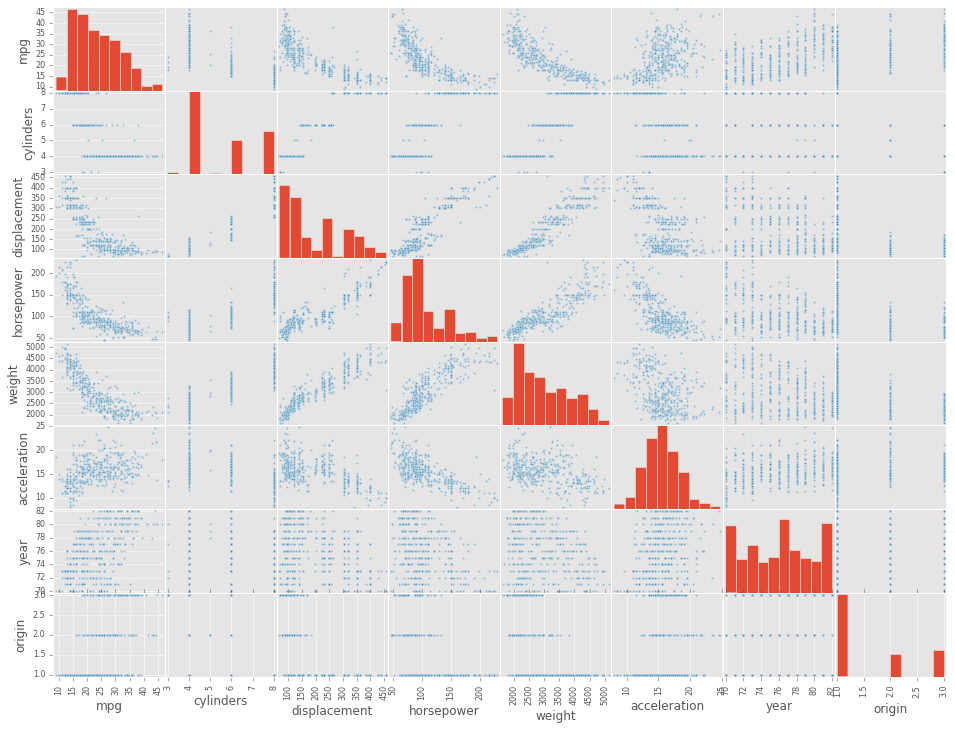

In [62]:
scatter_matrix(auto_df,alpha=0.5, figsize=(16,12));

## Compute Variable Correlation Matrix

In [9]:
# Call pandas corr, it ignores qualitative 'names' column
auto_df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


## Perform Multiple Linear Regression

#### Regress all predictors onto MPG response.

In [12]:
# Create the design matrix (exclude mpg and name-- 0th and 8th columns)
X = sm.add_constant(auto_df.iloc[:,1:-1])
y = auto_df.mpg
# Construct model estimate and summarize
model = sm.OLS(y,X)
estimate = model.fit()
print(estimate.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Mon, 30 Jan 2017   Prob (F-statistic):          2.04e-139
Time:                        18:16:40   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

#### There is a relationship between the predictors and the response (mpg): the displacement, weight, year and origin variables have small p-values. 

#### The postive slope coeffecient for the year predictor indicates that for a one year increase the mpg increases by 0.75 mpg.

#### Note that the correlation between displacement, horsepower and weight is high indicating a collinearity problem. The coeffecients for theses variables are therefore suspect. Below we compute the variance inflation factors, cylinders, displacement, horsepower and weight have larger VIF's which again indicate multi-collinearity.

In [13]:
# Compute all the variance inflation factors
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIFs = [(predictor, variance_inflation_factor(X.values,_)) \
        for _,predictor in enumerate(list(X))] # list(X) returns column names of df

print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
const                763.558
cylinders            10.738
displacement         21.837
horsepower           9.944
weight               10.831
acceleration         2.626
year                 1.245
origin               1.772


## Perform Estimate Diagnostics

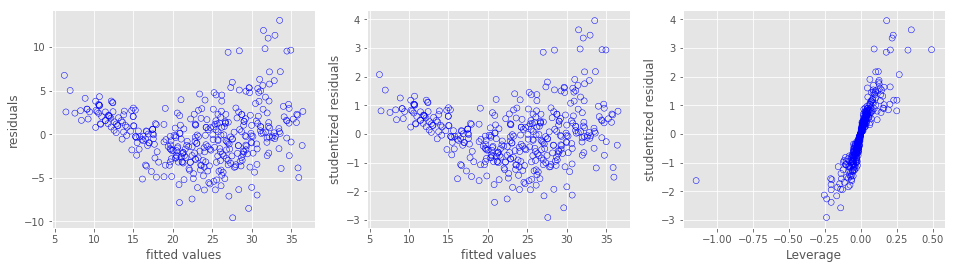

In [14]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

# Plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

# Residuals
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# Studentized Residuals
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('studentized residuals');
# Leverages
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b');
ax3.set_xlabel('Leverage');
ax3.set_ylabel('studentized residual');

#### The residuals plot indicates non-linearity in the data. The U-Shape means the fit is worse at the extreme values of the fit. The studentized residuals show multiple points are outliers ( > 3). The leverage plot shows several high leverage points. These are points that have leverages >> (p+1)/n= 8/392 ~ 0.02  Several of these points are also outliers. These points therefore strongly alter the coeffecient estimates.

## Fit a Model with Interaction Effects

In [15]:
# We will build an interaction model of the form mpg ~ const+weight+year+weight*year

auto_df['weight*year'] = auto_df.weight*auto_df.year
X_interaction = sm.add_constant(auto_df[['weight','year','weight*year']])
y = auto_df.mpg

# Construct model estimate and summarize
model = sm.OLS(y,X_interaction)
estimate = model.fit()
print(estimate.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     649.3
Date:                Mon, 30 Jan 2017   Prob (F-statistic):          8.06e-151
Time:                        18:20:55   Log-Likelihood:                -1009.3
No. Observations:                 392   AIC:                             2027.
Df Residuals:                     388   BIC:                             2043.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        -110.4519     12.947     -8.531      

#### The weight\*year interaction is significant. With a unit increase in weight\*year the mpg drops slightly but significantly. One way to think about this is that if weight is constant a unit increase in the year has a $\bf{\beta_2}$ increase in mpg and a decrease of $\bf{\beta_3*weight}$ from the interaction term

## Transform Variables

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     577.4
Date:                Mon, 30 Jan 2017   Prob (F-statistic):          1.21e-161
Time:                        18:21:42   Log-Likelihood:                -980.70
No. Observations:                 392   AIC:                             1971.
Df Residuals:                     387   BIC:                             1991.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const         -53.4414     14.093     -3.792      

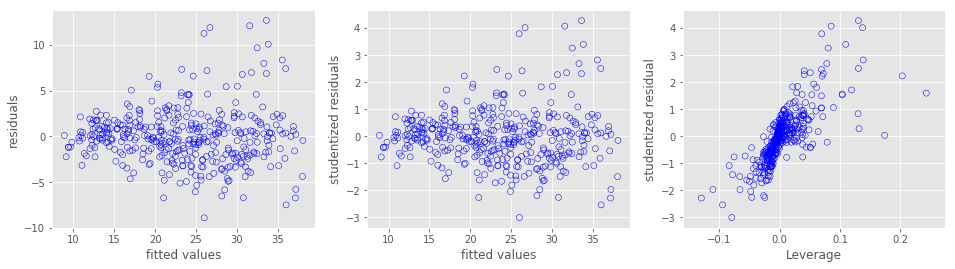

In [16]:
# Add a weight**2 variable along with the interaction between weight and year
auto_df['weight**2'] = auto_df.weight**2
X_quadratic = sm.add_constant(auto_df[['weight','weight**2','year', 'weight*year']])

# Construct model estimate and summarize
model = sm.OLS(y,X_quadratic)
quadratic_estimate = model.fit()
print(quadratic_estimate.summary())

# Diagnostic Plots

# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = quadratic_estimate.resid.values
studentized_residuals = OLSInfluence(quadratic_estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

# Plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

# Residuals
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# Studentized Residuals
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('studentized residuals');
# Leverages
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b');
ax3.set_xlabel('Leverage');
ax3.set_ylabel('studentized residual');


#### The weight${^2}$ is significant but the weight term is no longer. This makes sense when we consider the scatter plot of the mpg vs. weight. We also see less of a pattern in the residuals though at the highest mpgs we still are underestimating with our fit.